# 成交量指标策略
*市场短期是投票机，长期是称重机*

## 目录
1. 什么是成交量？
2. 如何计算成交量指标？
3. 如何用图形展示成交量？
4. 如何用成交量指标来编写策略？

## 什么是成交量？

成交量有三种可能，分别是量增、量减、量平。 

价格也有三种可能，分别是上涨、下跌、横盘。

量价理论表明价涨量增是上涨趋势的确认，反之价跌量增是下跌趋势的确认。

## 如何计算成交量指标？
---
### 1. ADV-平均成交量
$MA(volume,20)$

---

### 2. OBV
OBV属于市场的领先指标，计算方法是如果当天价格高于前一天的价格，当天成交量就用加的，反之就用减的来计算出OBV指标，这样有助于分析成交量与价格的关系。

---

### 3. A/D
A/D 指标在OBV的基础上对价格的波幅进行了计算，真实波幅越大，指标中的成交量占比越大。

$\frac{A}{D}=\frac{Close-Open}{High-Low}*Volume$

---

### 4. WVAP
按成交量来衡量价格的权重，成交量越大价格权重越大。

$sum(close * volume, 20)/sum(volume, 20)$

## 如何用图形展示成交量？

In [1]:
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import talib as ta
from talib import abstract

warnings.filterwarnings('ignore')

data = pd.read_excel('three.xlsx', sheetname='BTCUSDT.binance', index_col='datetime').iloc[-300:]

In [2]:
adv10 = abstract.MA(data, 10, price='volume')
adv20 = abstract.MA(data, 20, price='volume')

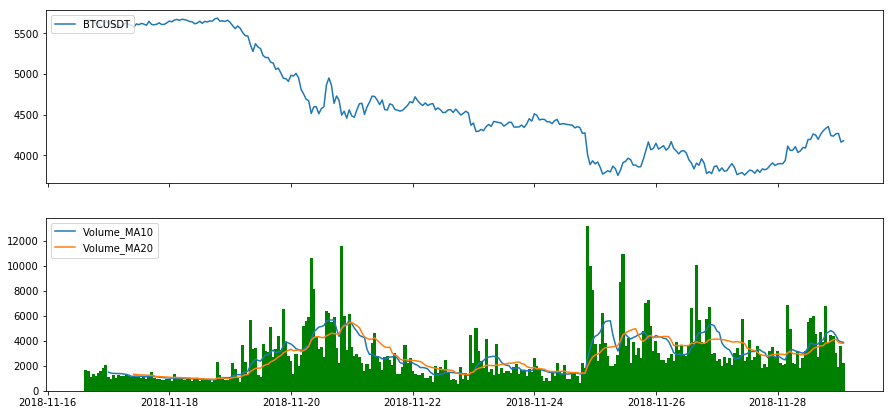

In [3]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(15,7))
ax.plot(data.close, label='BTCUSDT')
ax.legend(loc='upper left')
ax1.bar(data.index, data.volume, color='g', width=0.05)
ax1.plot(adv10, label='Volume_MA10')
ax1.plot(adv20, label='Volume_MA20')
plt.legend(loc='upper left')
plt.show()

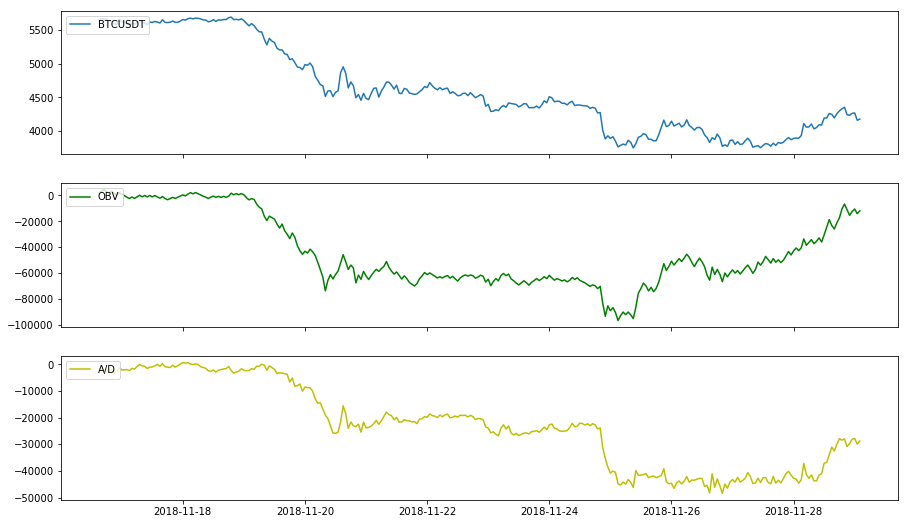

In [4]:
#OBV & A/D
OBV = abstract.OBV(data)
AD = abstract.AD(data)

fig, (ax, ax1,ax2) = plt.subplots(3, 1, sharex=True, figsize=(15,9))
ax.plot(data['close'], label='BTCUSDT')
ax.legend(loc='upper left')
ax1.plot(OBV,'g', label='OBV')
ax1.legend(loc='upper left')
ax2.plot(AD, 'y', label='A/D')
ax2.legend(loc='upper left')
plt.show()

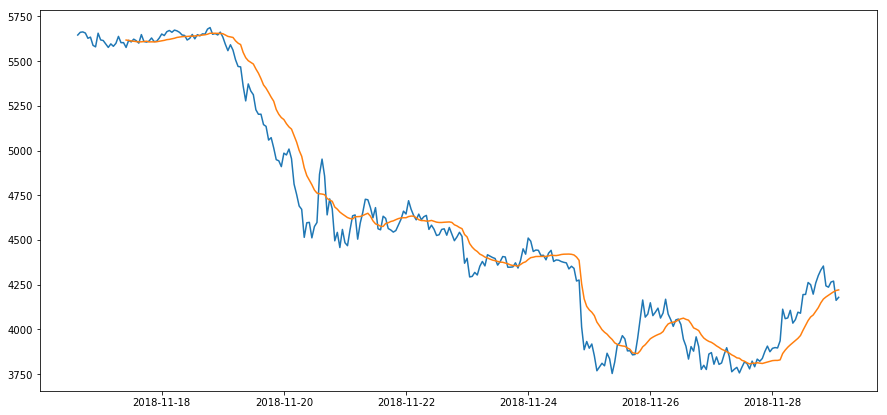

In [5]:
#vwap
VWAP=pd.Series(ta.SUM(data.close.values*data.volume.values, 20),index=data.index)/\
     pd.Series(ta.SUM(data.volume.values, 20),index=data.index)

plt.figure(figsize=(15,7))
plt.plot(data['close'])
plt.plot(VWAP)
plt.show()

## 如何用成交量指标来编写策略？
### VWAP策略
买入：

close>VWAP

卖出：

close<VWAP


In [ ]:
#VWAP
# 策略参数
VWAPPeriod = 70
lot = 1

# 信号计算
VWAP = ta.SUM(am.close*am.volume, self.VWAPPeriod) / ta.SUM(am.volume, self.VWAPPeriod)

# 现象条件
breakUpVwap = (am.close[-1] > VWAP[-2]) and (am.close[-2] <= VWAP[-2])
breakDnVwap = (am.close[-1] < VWAP[-2]) and (am.close[-2] >= VWAP[-2])

# 进出场条件
if breakUpVwap and (self.posDict[symbol + "_LONG"]==0):
    if self.posDict[symbol + "_SHORT"] == 0:
        self.buy(symbol, bar.close * 1.01, self.lot)
    elif self.posDict[symbol + "_SHORT"] > 0:
        self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
        self.buy(symbol, bar.close * 1.01, self.lot)
elif breakDnVwap and (self.posDict[symbol + "_SHORT"]==0):
    if self.posDict[symbol + "_LONG"] == 0:
        self.short(symbol, bar.close * 0.99, self.lot)
    elif self.posDict[symbol + "_LONG"] > 0:
        self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
        self.short(symbol, bar.close *0.99, self.lot)

## 作业
参考以上代码用其他成交量指标做策略